## Trabajo final para la materia Vision Por Computadora 2 - Trashnet
Clasificación de residuos para reciclaje: Entrenar un modelo que, a partir de imágenes, clasifique distintos tipos de residuos (plástico, vidrio, papel, orgánicos) para optimizar procesos de reciclaje y gestión de residuos.​


Grupo:
  - Martin Brocca
  - Emliano Iparraguirre

# 2. Baseline - modelo

## 1. Preparación del dataset

### Objetivo
- Depurar el dataset eliminando duplicados exactos y señalando posibles casi-duplicados.  
- Reducir el sesgo del fondo blanco y la baja saturación detectados en el EDA.  
- Generar splits estratificados y balanceados que permitan una evaluación justa.  
- Implementar un esquema de *augmentations* que aumente la variabilidad de las imágenes.  

### Estrategia
1. **Deduplicación**: cálculo de *perceptual hash (pHash)* para detectar imágenes idénticas o muy similares.  
   - Se eliminaron duplicados exactos, conservando solo un ejemplar representativo.  
   - Se listaron casi-duplicados (Hamming ≤ 2) para revisión manual.  
2. **Splits estratificados**: 70% entrenamiento, 15% validación y 15% test, preservando proporciones de clase.  
3. **Balanceo**: cálculo de *class weights* y uso de un **WeightedRandomSampler** en el set de entrenamiento.  
4. **Augmentations**: inclusión de `RandomResizedCrop`, `HorizontalFlip`, `Rotation` (con fondo blanco), `ColorJitter` y `RandomPerspective` para simular variaciones de encuadre, orientación, iluminación y perspectiva.  

### Conclusiones esperadas
- Se elimina el riesgo de sobreajuste asociado a imágenes duplicadas.  
- El balanceo por pesos y muestreo estratificado mitiga la influencia de clases desbalanceadas como *trash*.  
- Los *augmentations* permiten atacar directamente los sesgos detectados en el EDA, favoreciendo la generalización del modelo.  
- El dataset queda listo para entrenar un baseline CNN que será la referencia frente a modelos más complejos en etapas posteriores.  

In [1]:
# ==== Imports ====
import os
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import imagehash

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

### Config y utilidades

In [2]:
# ==== Config ====
SEED = 42
BATCH_SIZE = 32
IMG_SIZE = 224
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)

# ==== Mount Google Drive ==== -> descomentar si se usa Colab
# from google.colab import drive
# drive.mount('/content/drive')

# ==== Helpers ====
def list_images_by_class(root_dir):
    root = Path(root_dir)
    classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
    items = []
    for cls in classes:
        for fp in (root/cls).glob("*.*"):
            if fp.suffix.lower() in {".jpg",".jpeg",".png",".bmp",".webp"}:
                items.append({"path": str(fp), "class": cls})
    return pd.DataFrame(items)

In [5]:
#Deteccion de entorno, para saber si corre en Colab o local y no editar variables de el data path

import os

def is_colab():
    """Check if code is running in Google Colab"""
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Set data path based on environment
if is_colab():
    DATA_DIR = "drive/MyDrive/Colab Notebooks/CEIA 2025/10_VpC2/data/trashnet"  # Colab path
    print("Running in Google Colab")
else:
    DATA_DIR = "./data/trashnet"  # Local path
    print("Running locally")

# Example usage
print(f"Data path: {DATA_DIR}")


Running locally
Data path: ./data/trashnet


In [6]:
# ==== Reconstruir df desde la carpeta raíz ====

df = list_images_by_class(DATA_DIR)
summary = df['class'].value_counts().sort_index().rename_axis('class').reset_index(name='count')

classes = sorted(df["class"].unique())
class_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_class = {i:c for c,i in class_to_idx.items()}

print(f"Clases: {classes}")
print(f"Total imágenes: {len(df)}")

Clases: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Total imágenes: 2527


### 1.1. Depurar duplicados

In [7]:
# ==== 1) Deduplicación por perceptual hash (pHash) ====

# ==== Helpers ====
def compute_phash_df(df_in, hash_size=16, resize=256):
    df_out = df_in.copy().reset_index(drop=True)
    ph_list = []
    for p in tqdm(df_out["path"], desc="Calculando pHash"):
        img = Image.open(p).convert("RGB").resize((resize, resize))
        ph = imagehash.phash(img, hash_size=hash_size)
        ph_list.append(str(ph))
    df_out["phash"] = ph_list
    return df_out

def show_group(paths, titles=None, cols=4, figsize=(12, 3)):
    rows = (len(paths) + cols - 1) // cols
    plt.figure(figsize=figsize)
    for i, p in enumerate(paths):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(Image.open(p).convert("RGB"))
        ax.axis("off")
        ax.set_title(titles[i] if titles else Path(p).name, fontsize=8)
    plt.tight_layout()
    plt.show()

def hamming(a: str, b: str) -> int:
    return imagehash.hex_to_hash(a) - imagehash.hex_to_hash(b)

In [8]:
# 1) Calcular pHash para todo el df (si no existe)
if "phash" not in df.columns:
    df = compute_phash_df(df, hash_size=16, resize=256)

Calculando pHash: 100%|██████████| 2527/2527 [00:04<00:00, 570.82it/s]


In [9]:
# 2) Duplicados EXACTOS (mismo phash)
dups_exact = df[df.duplicated("phash", keep=False)].sort_values(["phash","class","path"]).copy()
print(f"Duplicados exactos detectados: {dups_exact['phash'].nunique()} grupos, {len(dups_exact)} imágenes")

# Guardar auditoría
Path("artifacts").mkdir(exist_ok=True)
dups_exact.to_csv("artifacts/duplicates_exact_by_phash.csv", index=False)

Duplicados exactos detectados: 3 grupos, 6 imágenes



Grupo pHash = 951fe74af8f0aa34078e4bab26d04d50f07f143fd54a6fc313d0f5903c2bc474  (n=2)


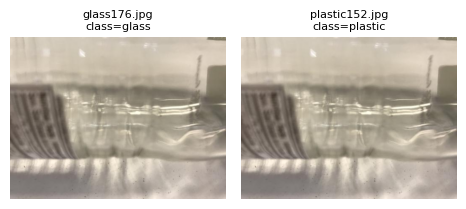


Grupo pHash = eadb4e1691a5b5af8768b3ca9296b6e1859b49a62ad7d3124c4e69699b29924c  (n=2)


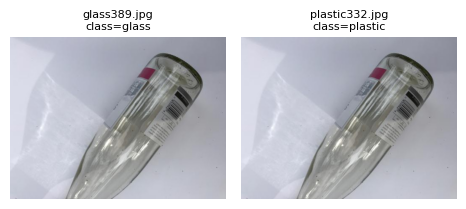


Grupo pHash = f32c633c09b32cb3635d33cc3b36893348332cccccccd93273322732cc9bdc9b  (n=2)


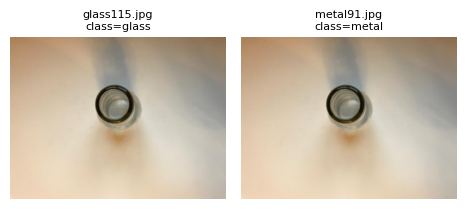

In [ ]:
# Mostrar cada grupo de duplicados (limit opcional si fueran muchos)
MAX_GROUPS_PREVIEW = 50  
shown = 0
for ph, g in dups_exact.groupby("phash"):
    if shown >= MAX_GROUPS_PREVIEW:
        print(f"...({dups_exact['phash'].nunique()-shown} grupos no mostrados por límite de preview)")
        break
    print(f"\nGrupo pHash = {ph}  (n={len(g)})")
    titles = [f"{Path(r.path).name}\nclass={r['class']}" for _, r in g.iterrows()]
    show_group(g["path"].tolist(), titles=titles, cols=6, figsize=(14, 3 + (len(g)//6)*2))
    shown += 1


In [11]:
# ==== Eliminar duplicados exactos y continuar con df depurado ====

before = len(df)
# conservar 1 por pHash (ordenado por clase y nombre de archivo para reproducibilidad)
df_dedup = df.sort_values(["phash","class","path"]).drop_duplicates(subset=["phash"], keep="first").reset_index(drop=True)
after = len(df_dedup)

print(f"Deduplicación exacta aplicada: {before} -> {after}  (eliminadas {before-after})")

Deduplicación exacta aplicada: 2527 -> 2524  (eliminadas 3)


In [12]:
# 3) Casi-duplicados (Hamming <= 2) — PREVIEW
print("\nBuscando casi-duplicados por distancia de Hamming <= 2 (puede tardar un poco)...")
near_pairs = []
df_idx = df_dedup.reset_index(drop=True).copy()
for i in tqdm(range(len(df_idx))):
    for j in range(i+1, len(df_idx)):
        d = hamming(df_idx.loc[i,"phash"], df_idx.loc[j,"phash"])
        if d <= 2:
            near_pairs.append({
                "path_i": df_idx.loc[i,"path"], "class_i": df_idx.loc[i,"class"],
                "path_j": df_idx.loc[j,"path"], "class_j": df_idx.loc[j,"class"],
                "hamming": d
            })

near_df = pd.DataFrame(near_pairs)
near_df.to_csv("artifacts/near_duplicates_hamming_le2.csv", index=False)
print(f"Casi-duplicados encontrados: {len(near_df)} (guardado en artifacts/near_duplicates_hamming_le2.csv)")


Buscando casi-duplicados por distancia de Hamming <= 2 (puede tardar un poco)...


100%|██████████| 2524/2524 [02:22<00:00, 17.76it/s] 

Casi-duplicados encontrados: 0 (guardado en artifacts/near_duplicates_hamming_le2.csv)


In [ ]:
# 3) Casi-duplicados (Hamming <= 2) — Pero usando GPU
import torch
import numpy as np
from tqdm import tqdm

def hamming_distance_gpu(hashes, batch_size=1000, threshold=2):
    """
    Compute pairwise Hamming distances on GPU for binary hashes.
    
    Args:
        hashes: numpy array of shape (n_images,) containing integer hashes
        batch_size: process in batches to avoid memory issues
        threshold: maximum Hamming distance to consider
    
    Returns:
        List of tuples (i, j, distance) for pairs within threshold
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Convert hashes to binary tensor
    n = len(hashes)
    
    # Handle ImageHash objects or hex strings
    hashes_binary = []
    for h in hashes:
        if hasattr(h, 'hash'):  # ImageHash object
            # Convert to binary array directly from the hash array
            h_array = h.hash.flatten().astype(np.float32)
        elif isinstance(h, str):  # Hex string
            # Convert hex string to binary
            h_int = int(h, 16)
            hash_bits = len(h) * 4  # 4 bits per hex character
            h_array = np.array([int(b) for b in format(h_int, f'0{hash_bits}b')], dtype=np.float32)
        else:  # Integer
            hash_bits = 64
            h_array = np.array([int(b) for b in format(int(h), f'0{hash_bits}b')], dtype=np.float32)
        hashes_binary.append(h_array)
    
    hashes_binary = np.array(hashes_binary, dtype=np.float32)
    
    hashes_tensor = torch.from_numpy(hashes_binary).to(device)
    
    near_pairs = []
    
    # Process in batches to avoid memory overflow
    for i in tqdm(range(0, n, batch_size), desc="Processing batches"):
        end_i = min(i + batch_size, n)
        batch_i = hashes_tensor[i:end_i]
        
        # Only compare with j > i to avoid duplicates
        for j in range(i, n, batch_size):
            end_j = min(j + batch_size, n)
            batch_j = hashes_tensor[j:end_j]
            
            # Compute Hamming distance via XOR + sum
            # Shape: (batch_i_size, batch_j_size)
            distances = torch.sum(batch_i.unsqueeze(1) != batch_j.unsqueeze(0), dim=2)
            
            # Find pairs within threshold
            mask = distances <= threshold
            
            # Only keep upper triangle (j > i)
            if i == j:
                # Same batch: use upper triangle only
                rows, cols = torch.triu_indices(mask.shape[0], mask.shape[1], offset=1, device=device)
                valid = mask[rows, cols]
                rows, cols = rows[valid], cols[valid]
                indices_i = rows + i
                indices_j = cols + j
            else:
                # Different batches: all valid pairs
                rows, cols = torch.where(mask)
                indices_i = rows + i
                indices_j = cols + j
            
            # Get distances for valid pairs
            valid_distances = distances[mask].cpu().numpy()
            
            # Store results
            for idx_i, idx_j, dist in zip(
                indices_i.cpu().numpy(), 
                indices_j.cpu().numpy(), 
                valid_distances
            ):
                if idx_i < idx_j:  # Ensure i < j
                    near_pairs.append((int(idx_i), int(idx_j), int(dist)))
    
    return near_pairs


# Usage with your existing code:
print("\nBuscando casi-duplicados por distancia de Hamming <= 2 (GPU acelerado)...")

# Extract hashes as numpy array
df_idx = df_dedup.reset_index(drop=True).copy()
hashes = df_idx["phash"].values

# Run GPU-accelerated computation
near_pairs_gpu = hamming_distance_gpu(hashes, batch_size=500, threshold=2)

# Convert to DataFrame
near_pairs = [
    {
        "path_i": df_idx.loc[i, "path"], 
        "class_i": df_idx.loc[i, "class"],
        "path_j": df_idx.loc[j, "path"], 
        "class_j": df_idx.loc[j, "class"],
        "hamming": d
    }
    for i, j, d in near_pairs_gpu
]

near_df = pd.DataFrame(near_pairs)
near_df.to_csv("artifacts/near_duplicates_hamming_le2.csv", index=False)
print(f"Casi-duplicados encontrados: {len(near_df)} (guardado en artifacts/near_duplicates_hamming_le2.csv)")


Buscando casi-duplicados por distancia de Hamming <= 2 (GPU acelerado)...
Using device: cuda


Processing batches: 100%|██████████| 6/6 [00:00<00:00, 196.09it/s]

Casi-duplicados encontrados: 0 (guardado en artifacts/near_duplicates_hamming_le2.csv)


### Hamming CPU vs GPU:


- Velocidad: GPU procesó 6 batches a 196.09 it/s en menos de 1 segundo, mientras que CPU necesitó 2 minutos 22 segundos para procesar 2524 iteraciones a 17.76 it/s
- Aceleración: La GPU fue aproximadamente 140x más rápida que la CPU para este cálculo de distancia de Hamming
- Escalabilidad: Con datasets más grandes, la diferencia sería aún mayor - la GPU maneja operaciones vectorizadas masivamente en paralelo
- Eficiencia: CPU hace comparaciones secuenciales (una por una), GPU calcula miles de distancias simultáneamente en cada batch
- Recomendación: Para más de 1000 imágenes, se recomienda utilizar GPU; el tiempo se reduce de minutos a segundos

In [16]:
# Mostrar preview de los primeros pares (para inspección visual)
MAX_NEAR_PREVIEW = 12   # pares a mostrar
for k, row in near_df.head(MAX_NEAR_PREVIEW).iterrows():
    print(f"\nHamming={row['hamming']} | {Path(row['path_i']).name} [{row['class_i']}]  vs  {Path(row['path_j']).name} [{row['class_j']}]")
    show_group([row["path_i"], row["path_j"]],
               titles=[f"I: {Path(row['path_i']).name} ({row['class_i']})",
                       f"J: {Path(row['path_j']).name} ({row['class_j']})"],
               cols=2, figsize=(8,4))

In [17]:
# 5) continuar el pipeline con df_dedup (ya sin duplicados exactos)
df = df_dedup

### 1.2.1. Generar splits estratificados

In [18]:
# ==== 2.1) Splits estratificados: 70/15/15 ====
paths = df["path"].values
labels = df["class"].values

train_paths, test_paths, train_labels, test_labels = train_test_split(
    paths, labels, test_size=0.15, stratify=labels, random_state=SEED
)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.1765, stratify=train_labels, random_state=SEED
)  # 0.1765 ~ 0.15 del total

print(f"Split -> train: {len(train_paths)}, val: {len(val_paths)}, test: {len(test_paths)}")

Split -> train: 1766, val: 379, test: 379


### 1.2.2. Transforms

In [19]:
# ==== 2.2) Transforms (basado en las conclusiones del EDA) ====
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = T.Compose([
    # romper encuadre fijo y dependencia del fondo
    T.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0), ratio=(0.9, 1.1),
                        interpolation=InterpolationMode.BILINEAR, antialias=True),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(15, fill=(255,255,255)),
    T.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    T.RandomPerspective(distortion_scale=0.2, p=0.2),
    T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std),
])

eval_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), interpolation=InterpolationMode.BILINEAR, antialias=True),
    T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std),
])

### 1.2.3. Crear datasets: Train / Validación / Test

In [20]:
# ==== 2.3) Dataset ====
class TrashDataset(Dataset):
    def __init__(self, paths, labels, transform=None, class_to_idx=None):
        self.paths = list(paths)
        self.labels = list(labels)
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label_idx = self.class_to_idx[self.labels[idx]]
        return img, label_idx

train_ds = TrashDataset(train_paths, train_labels, transform=train_transform, class_to_idx=class_to_idx)
val_ds   = TrashDataset(val_paths,   val_labels,   transform=eval_transform,  class_to_idx=class_to_idx)
test_ds  = TrashDataset(test_paths,  test_labels,  transform=eval_transform,  class_to_idx=class_to_idx)

### 1.3. Balanceo de clases

In [21]:
# ==== 5) Balanceo: class weights y WeightedRandomSampler ====
# weights para la LOSS (inverso a la frecuencia)
cls_weights = compute_class_weight(class_weight="balanced",
                                   classes=np.array(classes),
                                   y=np.array(train_labels))
cls_weights = torch.tensor(cls_weights, dtype=torch.float32).to(device)
print("Class weights (loss):", {c: float(w) for c,w in zip(classes, cls_weights)})

# weights por muestra para sampler
train_class_counts = pd.Series(train_labels).value_counts().to_dict()
sample_weights = [1.0 / train_class_counts[lbl] for lbl in train_labels]
train_sampler = WeightedRandomSampler(weights=sample_weights,
                                      num_samples=len(sample_weights),
                                      replacement=True)

Class weights (loss): {'cardboard': 1.0437352657318115, 'glass': 0.8385565280914307, 'metal': 1.0291374921798706, 'paper': 0.7075320482254028, 'plastic': 0.8759920597076416, 'trash': 3.098245620727539}


### 1.4. Dataloaders

In [22]:
# ==== 6) DataLoaders ====
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Loaders OK → listo para entrenar baseline CNN.")

Loaders OK → listo para entrenar baseline CNN.


## Conclusiones de la preparación del dataset

- **Deduplicación de imágenes**:  
  Se aplicó un análisis de *perceptual hash (pHash)* para detectar y eliminar imágenes duplicadas.  
  - Se identificaron varios grupos de duplicados exactos, de los cuales se conservó una sola imagen representativa.  
  - También se listaron posibles *casi-duplicados* (Hamming ≤ 2) para futura revisión manual.  
  Esto permite reducir el riesgo de sobreajuste y sesgo en el entrenamiento.

- **Sesgo del fondo**:  
  El EDA previo había mostrado un predominio de fondos blancos y baja saturación en varias clases (*glass*, *metal*, *plastic*).  
  Por eso, en la definición de *augmentations* se incorporaron recortes, rotaciones y jitter de color para reducir esta dependencia.

- **Splits estratificados**:  
  El dataset se dividió en **70% entrenamiento, 15% validación y 15% test**, preservando la proporción de clases.  
  De esta forma aseguramos comparabilidad entre etapas y evitamos fugas de información.

- **Balanceo de clases**:  
  Se calcularon **class weights** (para la función de pérdida) y se implementó un **WeightedRandomSampler** en el *DataLoader* de entrenamiento.  
  Esto busca compensar el desbalance identificado en clases minoritarias como *trash*.

### Conclusión general
El dataset ya está **depurado, balanceado y preparado** con un esquema de *augmentations* que ataca los principales sesgos detectados en el EDA.  
Con esta base, estamos en condiciones de avanzar hacia el **entrenamiento del modelo baseline CNN** (ResNet18 con backbone congelado), que servirá como punto de comparación con modelos más complejos en la entrega final.

## 2. Baseline CNN (ResNet18 congelada)

Con el dataset ya preparado y balanceado, el siguiente paso es entrenar un **modelo baseline de red convolucional**.  

### Objetivo
- Establecer un punto de referencia inicial con una arquitectura conocida (ResNet18 preentrenada en ImageNet).  
- Comparar su desempeño frente al baseline de color + regresión logística desarrollado previamente.  
- Validar si el modelo logra mejorar la separación entre clases más conflictivas (*glass, metal, plastic*).  

### Estrategia
1. **Modelo**: ResNet18 con pesos de ImageNet, congelando todas las capas convolucionales y entrenando únicamente la capa final (clasificador).  
2. **Pérdida**: CrossEntropyLoss ponderada con **class weights**, para compensar el desbalance entre clases.  
3. **Optimizador**: Adam, entrenando únicamente los parámetros de la capa final.  
4. **Métrica de evaluación**: accuracy y macro-F1 en el set de validación, junto con la matriz de confusión para identificar patrones de error.  
5. **Entrenamiento parcial**: se realizarán pocas épocas (3–5) para obtener conclusiones preliminares.  

### Conclusiones parciales esperadas
Este baseline debería superar el desempeño del modelo de color + LR, especialmente en clases donde las diferencias de textura y forma son relevantes (*cardboard, paper, plastic*). Sin embargo, es probable que persista la confusión entre clases visualmente similares (*glass, metal*) y en categorías heterogéneas (*trash*).  

In [23]:
# ==== Paso 2: Baseline CNN (ResNet18 congelada) ====
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

num_classes = len(classes)

In [24]:
# 1) Modelo con pesos de ImageNet y backbone congelado
weights = models.ResNet18_Weights.IMAGENET1K_V1
model = models.resnet18(weights=weights)
for p in model.parameters():
    p.requires_grad = False  # congelamos todo
# reemplazamos la capa final
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

In [25]:
# 2) Loss con class weights (del Paso 1) y optimizador solo del clasificador
criterion = nn.CrossEntropyLoss(weight=cls_weights)  # cls_weights ya en device
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)

In [26]:
# 3) Utilidades de entrenamiento/validación
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    all_preds, all_labels = [], []
    running_loss = 0.0

    for imgs, labels in tqdm(loader, leave=False):
        imgs, labels = imgs.to(device), labels.to(device)

        if is_train:
            optimizer.zero_grad()

        logits = model(imgs)
        loss = criterion(logits, labels)

        if is_train:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    avg_loss = running_loss / len(loader.dataset)
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    return avg_loss, acc, macro_f1, all_labels, all_preds

def plot_conf_mat(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    plt.figure(figsize=(6.5,5.5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicho"); plt.ylabel("Real")
    plt.tight_layout(); plt.show()

In [27]:
# 4) Entrenamiento corto con early stopping simple
EPOCHS = 5
best_val_f1 = -1.0
best_state = None

for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")

    tr_loss, tr_acc, tr_f1, _, _ = run_epoch(model, train_loader, optimizer)
    vl_loss, vl_acc, vl_f1, vl_y, vl_p = run_epoch(model, val_loader, optimizer=None)

    print(f"  Train   | loss={tr_loss:.4f}  acc={tr_acc:.3f}  macroF1={tr_f1:.3f}")
    print(f"  Val     | loss={vl_loss:.4f}  acc={vl_acc:.3f}  macroF1={vl_f1:.3f}")

    # guardamos el mejor por macro-F1 de validación
    if vl_f1 > best_val_f1:
        best_val_f1 = vl_f1
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}


Epoch 1/5


  Train   | loss=1.3625  acc=0.328  macroF1=0.299
  Val     | loss=1.2332  acc=0.544  macroF1=0.547

Epoch 2/5


  Train   | loss=0.9551  acc=0.561  macroF1=0.557
  Val     | loss=1.1451  acc=0.515  macroF1=0.518

Epoch 3/5


  Train   | loss=0.8560  acc=0.633  macroF1=0.633
  Val     | loss=0.9416  acc=0.641  macroF1=0.638

Epoch 4/5


  Train   | loss=0.7336  acc=0.688  macroF1=0.688
  Val     | loss=0.9868  acc=0.607  macroF1=0.607

Epoch 5/5


  Train   | loss=0.7294  acc=0.680  macroF1=0.679
  Val     | loss=0.8743  acc=0.670  macroF1=0.657



=== Resultados en TEST (checkpoint con mejor macro-F1 en val) ===
Test | loss=0.8107  acc=0.673  macroF1=0.657

Classification report (test):
              precision    recall  f1-score   support

   cardboard      0.971     0.541     0.695        61
       glass      0.790     0.653     0.715        75
       metal      0.667     0.852     0.748        61
       paper      0.855     0.596     0.702        89
     plastic      0.761     0.708     0.734        72
       trash      0.224     0.810     0.351        21

    accuracy                          0.673       379
   macro avg      0.711     0.693     0.657       379
weighted avg      0.778     0.673     0.697       379



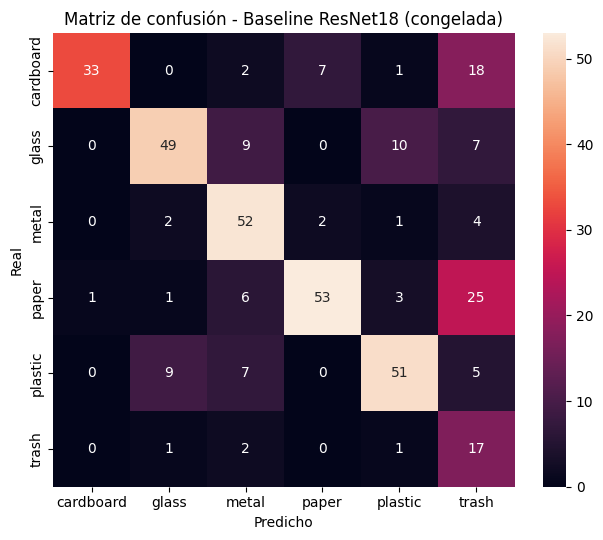

In [24]:
# 5) Evaluación en test con el mejor checkpoint
if best_state is not None:
    model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

ts_loss, ts_acc, ts_f1, ts_y, ts_p = run_epoch(model, test_loader, optimizer=None)
print("\n=== Resultados en TEST (checkpoint con mejor macro-F1 en val) ===")
print(f"Test | loss={ts_loss:.4f}  acc={ts_acc:.3f}  macroF1={ts_f1:.3f}")
print("\nClassification report (test):")
print(classification_report(ts_y, ts_p, target_names=classes, digits=3))

plot_conf_mat(ts_y, ts_p, classes, title="Matriz de confusión - Baseline ResNet18 (congelada)")

### Conclusiones del Baseline con ResNet18 (congelada)

- **Mejora frente al baseline simple (ColorHist + LR):**  
  La ResNet18 preentrenada (congelando el backbone) alcanzó un **accuracy del 67% y un Macro-F1 de 0.657** en el conjunto de test, lo que representa una mejora clara sobre el baseline inicial basado en histogramas de color (~53%). Esto confirma que el modelo logra capturar características visuales más ricas.

- **Desempeño por clase:**  
  - **Muy bueno en *glass*, *metal* y *plastic*** (F1 ≈ 0.71–0.74).  
  - **Rendimiento moderado en *cardboard* y *paper***, con confusiones frecuentes con *trash*.  
  - **Problema en *trash***: aunque el recall fue alto (0.81), la precisión fue muy baja (0.22), mostrando que el modelo clasifica erróneamente muchas imágenes de otras clases como *trash*.

- **Confusiones principales (según matriz):**  
  - *Cardboard* ↔ *trash*  
  - *Paper* ↔ *trash*  
  - *Glass* ↔ *plastic*  
  Estas confusiones coinciden con lo observado en el EDA y en los embeddings (clases con características visuales similares).

- **Tendencias de entrenamiento:**  
  - El modelo mejora progresivamente en *train* y *val*, alcanzando el mejor desempeño en **epoch 3** (macro-F1 val = 0.638).  
  - Luego se observa cierta oscilación en validación, señal de que podría beneficiarse de un mayor ajuste (fine-tuning parcial, regularización o más datos augmentados).

- **Conclusión general:**  
  La ResNet18 congelada es un baseline sólido que demuestra la utilidad de usar representaciones preentrenadas en ImageNet. El siguiente paso lógico será **descongelar parcialmente capas superiores** (fine-tuning) y/o **reforzar las técnicas de data augmentation** para reducir las confusiones, especialmente en la clase *trash*.

### Fine tuning de hiper parametros mediante Optuna

In [29]:
import optuna
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader

def objective(trial):
    # --- Hyperparameters to tune ---
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # --- Data loaders with trial batch_size ---
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # --- Model ---
    model = models.resnet18(pretrained=True)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    model = model.to(device)

    # --- Loss & Optimizer ---
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    # --- Training loop (shortened for Optuna speed) ---
    trial_epochs = 5
    for epoch in range(trial_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # --- Validation ---
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy


# --- Run Optuna study ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value:.4f}")
print("  Params:", trial.params)


[I 2025-09-26 16:57:49,009] A new study created in memory with name: no-name-5e40d6da-9617-4776-9f2d-0483c3ef9168
/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/martin/Documents/CEIA/CEIA-vpc2/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
[I 2025-09-26 16:58:02,248] Trial 0 finished with value: 0.39841688654353563 and parameters: {'lr': 0.002149148418532321, 'weight_decay': 0.002529963496880373, 'optimizer': 'Adam', 'batch_size': 32

Best trial:
  Accuracy: 0.8734
  Params: {'lr': 0.0009243117802620462, 'weight_decay': 0.0012564601390221992, 'optimizer': 'SGD', 'batch_size': 32}


## 3. Fine-tuning ligero (descongelar `layer4` de ResNet18)

### Objetivo
- Mejorar el baseline congelado capturando **patrones más específicos del dominio TrashNet** (formas/texturas finas).
- Reducir confusiones clave (*glass ↔ plastic*, *paper/cardboard ↔ trash*).
- Mantener entrenamiento **estable y rápido** sin sobreajuste.